# Homework 4: 
## Riccardo Tancredi - riccardo.tancredi@studenti.unipd.it
---
Using non-homogeneous Poisson process, generate the spike train of 100 neurons (if your code is efficient you can also do more, e.g. 200 or 1000)

Do this for two different situations:

1) The firing rate $\lambda_t$ **is independent for each neuron**, and generated as random variables extracted each time step by an exponential distribution $p(\lambda_t)= r \exp\big[- r \lambda_t\big]$ with $r=0.2$. 

2) The firing rate $\lambda_t$ **is the same for each neuron**, and generated as random variables extracted each time step by an exponential distribution $p(\lambda_t)= r \exp \big[- r \lambda_t\big]$ with $r=0.2$. 

For both cases you can use a time step $dt=0.01$. I remember you that the probability of a spike is $\lambda_t \cdot dt$. Do at least 1000 timesteps.

What is the differences in terms of neural avalanches for the two cases? You can, if you want, characterize the avalanches size distributions, remembering that an avalanche size is defined as the total number of neurons spiking between the period of total silence (no neurons spiking).

Optional: compute the avalanche durations analytically using the same parameters of the simulations for the two cases. The full calculations are available in the notes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 10})  
np.random.seed(8122023)

In [2]:
n = 300     # number of neurons
T = 1_000   # total number of timesteps
dt = 0.01   # time step
r = 0.2     # gamma factor

To sample from an exponetial distribution of the form $p(\lambda_t) = r \exp \big[-r\lambda_t \big]$, one can compute the cumulative distribution $P(\lambda_t) = 1-\exp\big[-r\lambda_t \big]$. Using the inversione method, since the **CDF** is a monotonic function, we can sample a random number $u\in[0, 1]$ and then compute $\lambda_t$ as 
\begin{equation*}
    P(\lambda_t) = u \iff \boxed{\lambda_t = -\log(1-u)/r}
\end{equation*}
where $\lambda_t$ can be different for each neuron (1. case) so one has to sample $\lambda_t^{(i)}$ for $t\in \{0, T\}$ and $i\in\{1, n\}$, where $n$ is the total number of neurons, or (2. case) a unique $\lambda_t$ for $t\in \{0, T\}$ for each neuron.

In [3]:
# 1. Firing rates independent for each neuron
firing_rates_per_neuron_at_time_t = np.array([-np.log(1-np.random.uniform(size=int(T/dt)))/r for i in range(n)])
# Homogeneous step:
prob_of_spike = firing_rates_per_neuron_at_time_t*dt
validate_prob = np.random.uniform(size=(firing_rates_per_neuron_at_time_t.shape))
mask = validate_prob < prob_of_spike
firing_rates_per_neuron_at_time_t[~mask] = 0 

# In this manner, a spike train has been generated for a homogeneous Poisson process
# For an inhomogeneous process the rejection sampling and the thinning techniques are introduced  
firing_rates_max = firing_rates_per_neuron_at_time_t.max(axis=1) # find the max λ(t) for each t
# Thinning method:
new_mask = np.array([firing_rates_per_neuron_at_time_t[i]/firing_rates_max[i] for i in range(n)]) < np.random.uniform(size=(firing_rates_per_neuron_at_time_t.shape))
firing_rates_per_neuron_at_time_t[new_mask] = 0     # set these elements to 0: Thinning technique
mask_tot = firing_rates_per_neuron_at_time_t != 0   # mask resembling where the firing rates are not 0

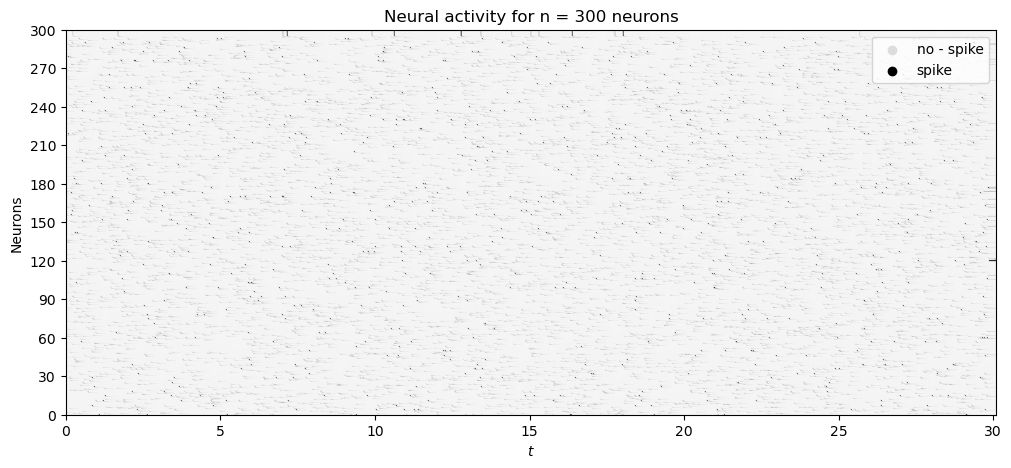

In [4]:
# Plot of the activity distribution of each neuron in time
tau = 3*T
x = np.arange(0, T, dt)[:tau]
X, Y = np.meshgrid(x, np.arange(mask_tot.shape[0]))
colors = np.where(mask_tot == 0, 'whitesmoke', 'black')[:, :tau]
plt.figure(figsize=(12, 5))
spacing = int(n/10)
for i in range(n):
    plt.scatter(X[i, :], spacing*Y[i, :], marker=',', color=colors[i, :], alpha=0.7)
plt.scatter([], [], label=f'no - spike', color='gainsboro')
plt.scatter([], [], label=f'spike', color='black')
plt.xlim((0, x[-1]+0.1))
plt.yticks(np.arange(0, n+spacing, spacing)*spacing, np.arange(0, n+spacing, spacing))
plt.ylim((0, spacing*n))
plt.title(f'Neural activity for n = {n} neurons')
plt.xlabel(r'$t$')
plt.ylabel(f'Neurons')
plt.legend(loc='upper right')
plt.show()

From the above plot it is immediate to observe a complete random behaviour of the distribution of the spiking neurons. This is something that someone can expect since all the $\lambda_t^{(i)}$ are randomly and independently generated.

The plot below respresents instead a zoom-in of the previous picture, drawing the spikes of 4 randomly selected neurons among the $n$ available.

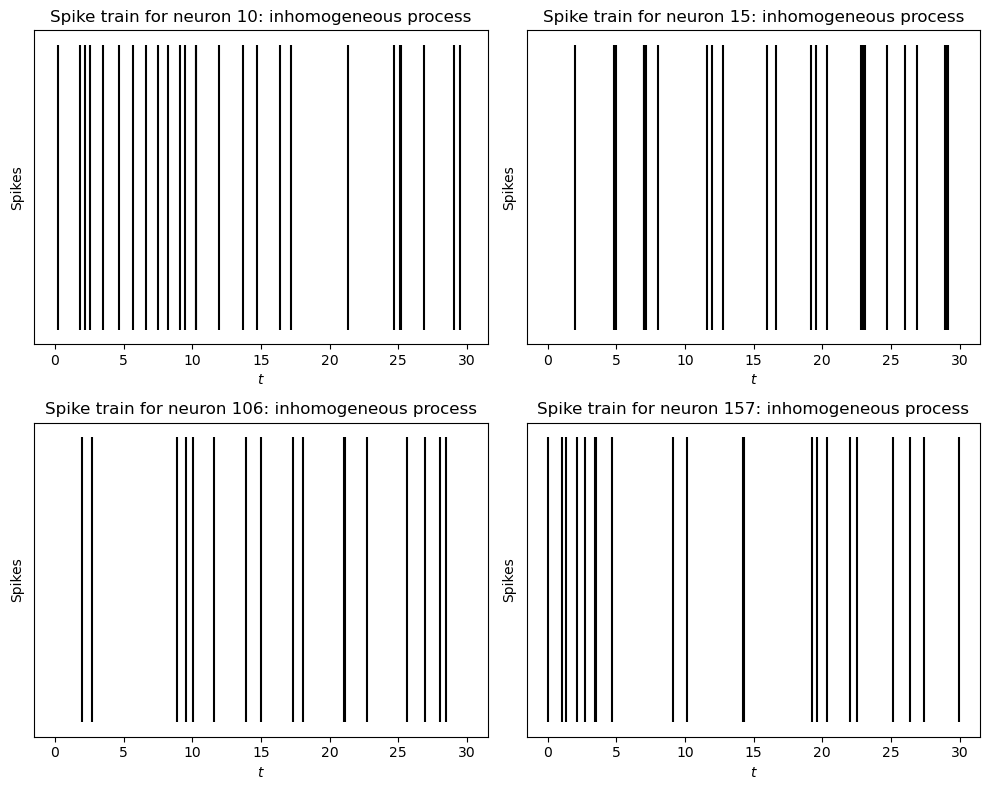

In [5]:
# firing rate plot
rand_neuron_visual = sorted(np.random.randint(0, n, 4))

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
for k, i in enumerate(rand_neuron_visual):
    row, col = bin(k).split('b')[-1].zfill(2)
    ax[int(row), int(col)].vlines((np.arange(0, T, dt))[:tau], 0, mask_tot[i][:tau], color='k')
    ax[int(row), int(col)].set_xlabel(r'$t$')
    ax[int(row), int(col)].set_ylabel(f'Spikes')
    ax[int(row), int(col)].set_title(f'Spike train for neuron {i+1}: inhomogeneous process')
    ax[int(row), int(col)].set_yticks([])

plt.tight_layout()
plt.show()

In order to compute the probability of an avalanche in the case of an inhomogeneous Poisson process, it is possible to use several methods. The main one takes into account the total number of spikes in a *time window*, a region delimited by the firing of no neurons. I identify where these time windows are settled and how long they last.

In [6]:
# 'mask_tot' describes where the firing rates are different than zero
# First goal: find where no neurons are spiking. Essentialy, 
# a column in the 'mask_tot' variable where all elements are equal to 'False'
# I keep track of the times when this happens (if it happens)
no_spike_t = np.where(mask_tot.sum(axis=0) == 0)[0]
no_spike_t = np.insert(no_spike_t, 0, 0) # add initial time t_0 = 0s
avalanche_duration = np.diff(no_spike_t)
avalanche_size_window = np.zeros_like(avalanche_duration)
for i, t in enumerate(no_spike_t[1:]):
    # count the number of spiking neurons in the considered time window
    avalanche_size_window[i] = mask_tot[:, no_spike_t[i]:t].sum() 
    # in this manner a neuron spiking m times is of course counted m times

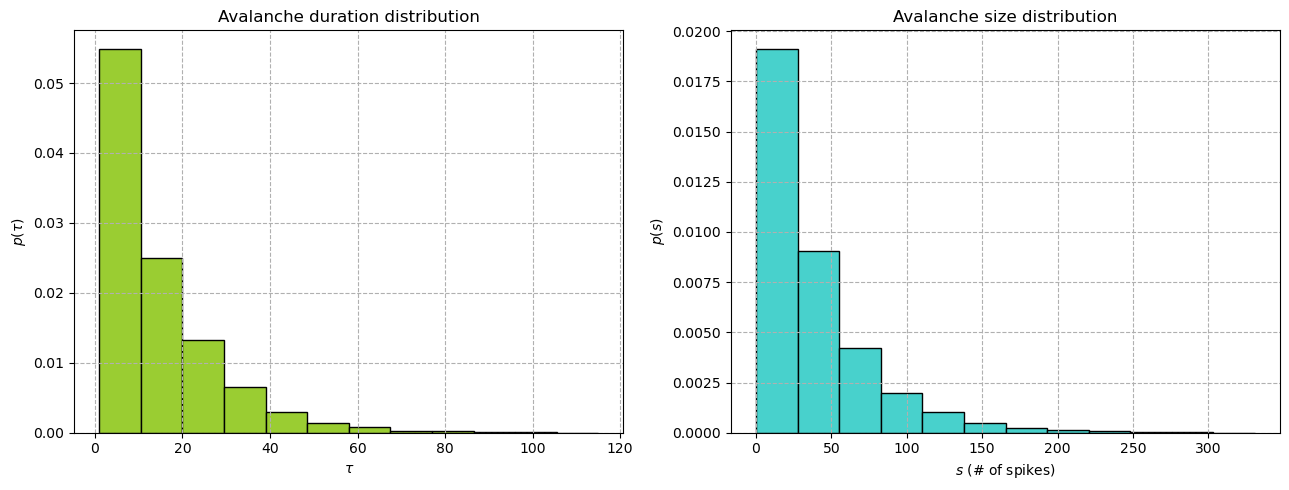

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
t_points, t_bins, _ = ax[0].hist(avalanche_duration, bins=12, 
           facecolor='yellowgreen', edgecolor='black', density=True)
ax[0].grid(ls='--')
ax[0].set_title(f'Avalanche duration distribution')
ax[0].set_xlabel(r'$\tau$')
ax[0].set_ylabel(r'$p(\tau)$')

s_points, s_bins, _ = ax[1].hist(avalanche_size_window, bins=12, 
           facecolor='mediumturquoise', edgecolor='black', density=True)
ax[1].grid(ls='--')
ax[1].set_title(f'Avalanche size distribution')
ax[1].set_xlabel(r'$s$'+f' (# of spikes)')
ax[1].set_ylabel(r'$p(s)$')

plt.tight_layout()
plt.show()

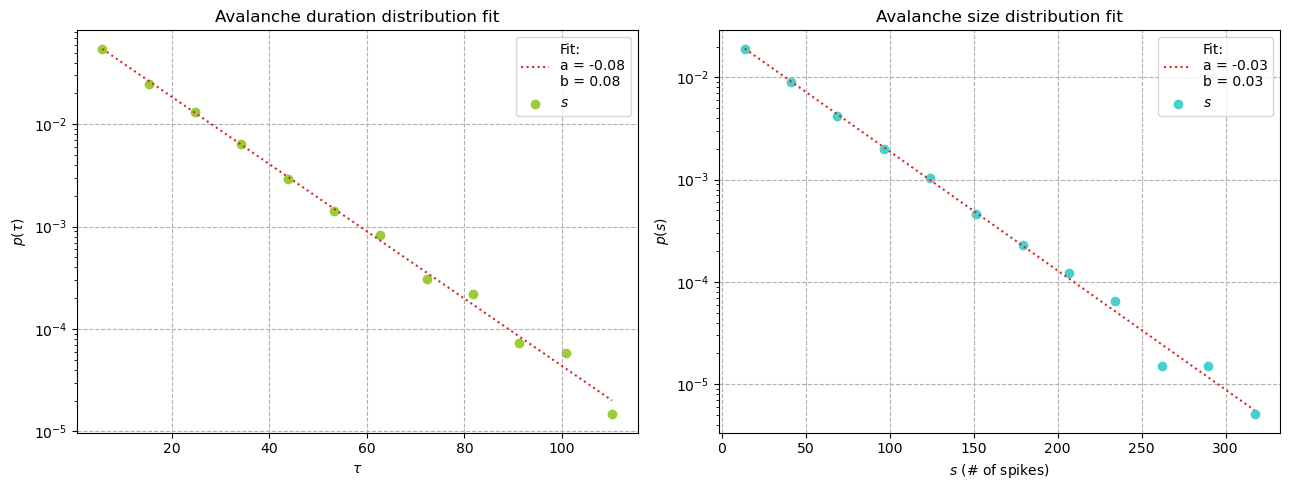

In [8]:
# Fit the avalanche size distribution
xx = (s_bins[1:]+s_bins[:-1])/2
popt, pcov = curve_fit(lambda x, a, b : a*x+b, xx[s_points != 0], np.log(s_points[s_points != 0])) 
x = np.linspace(min(xx), max(xx), 100)
theor_p = (lambda x, a, b : np.exp(b+x*a))(x, *popt)

# Fit the avalanche duration distribution
xx_t = (t_bins[1:]+t_bins[:-1])/2
popt_t, pcov_t = curve_fit(lambda x, a, b : a*x+b, xx_t[t_points != 0], np.log(t_points[t_points != 0])) 
x_t = np.linspace(min(xx_t), max(xx_t), 100)
theor_t = (lambda x, a, b : np.exp(b+x*a))(x_t, *popt_t)


fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].plot(x_t, theor_t, color='tab:red', ls=':', label=f'Fit:\na = {round(popt_t[0], 2)}\nb = {round(np.exp(popt_t[1]), 2)}')
ax[0].scatter(xx_t, t_points, marker='o', color='yellowgreen', label=r'$s$')
ax[0].set_xlabel(r'$\tau$')
ax[0].set_ylabel(r'$p(\tau)$')
ax[0].grid(ls='--')
ax[0].set_title(f'Avalanche duration distribution fit')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(x, theor_p, color='tab:red', ls=':', label=f'Fit:\na = {round(popt[0], 2)}\nb = {round(np.exp(popt[1]), 2)}')
ax[1].scatter(xx, s_points, marker='o', color='mediumturquoise', label=r'$s$')
ax[1].set_xlabel(r'$s$'+f' (# of spikes)')
ax[1].set_ylabel(r'$p(s)$')
ax[1].grid(ls='--')
ax[1].set_title(f'Avalanche size distribution fit')
ax[1].set_yscale('log')
ax[1].legend()

plt.tight_layout()
plt.show()

The picture above represents the **exponential** behaviour of the avalanche size and duration distribution. The points follow an exponetial distribution of the form $p(s)\sim e^{a\cdot s}$.

If instead one simply counts the number of active neurons at each time step $dt$, that the distribution followed is a Poisson converging to a Gaussian, the more picked to a certain value the higher the number of neurons $n$. In the plot below a power law and a Gaussian fit are presented, highlighting the randomic behaviour of this case with firing rates indepedent for each neuron.

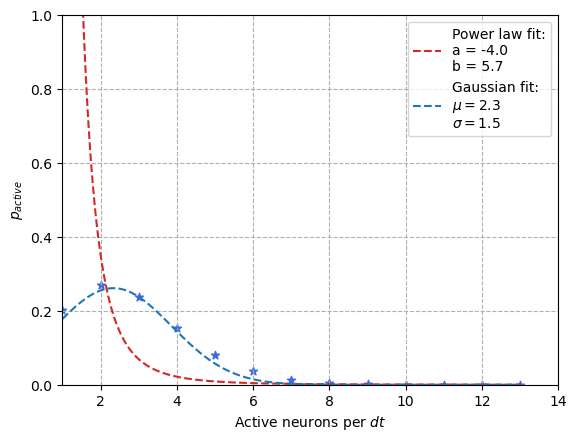

In [9]:
active_neurons_per_dt = mask_tot.sum(axis=0) # (~mask_tot == [False]*int(T/dt)).sum(axis=0)

power_law = np.array([(active_neurons_per_dt == i).sum() for i in np.unique(active_neurons_per_dt)[1:]])
power_law = power_law/np.sum(power_law)

popt, pcov = curve_fit(lambda x, a, b: a*x+b, np.log(np.unique(active_neurons_per_dt)[1:]), np.log(power_law))
x = np.linspace(1, max(np.unique(active_neurons_per_dt)), n)
theor = (lambda x, a, b: np.exp(b)*x**a)(x, *popt)

popt_g, pcov_g = curve_fit(lambda x, loc, scale: np.exp(-0.5*((x-loc)/scale)**2)/np.sqrt(2*np.pi*scale**2), 
                           np.unique(active_neurons_per_dt)[1:], power_law)
theor_g = (lambda x, loc, scale: np.exp(-0.5*((x-loc)/scale)**2)/np.sqrt(2*np.pi*scale**2))(x, *popt_g)

plt.scatter(np.unique(active_neurons_per_dt)[1:], power_law, color='royalblue', marker='*')
plt.plot(x, theor, color='tab:red', ls='--', label=f'Power law fit:\na = {round(popt[0], 1)}\nb = {round(np.exp(popt[1]), 1)}')
plt.plot(x, theor_g, color='tab:blue', ls='--', label=f'Gaussian fit:\n'+r'$\mu='+f'{round(popt_g[0], 1)}'+r'$'+f'\n'+r'$\sigma='+f'{round(popt_g[1], 1)}'+r'$')
plt.xlabel(r'Active neurons per $dt$')
plt.ylabel(r'$p_{active}$')
# plt.xscale('log')
plt.xlim((1, max(np.unique(active_neurons_per_dt))+1))
# plt.yscale('log')
plt.ylim((0, 1))
plt.grid(ls='--')
plt.legend()
plt.show()

To compute the probability of an **avalanche** (in the case of an inhomogeneous Poisson process), one has to consider the probability 
\begin{equation*}
    \mathbb{P}_> (t\big\vert\lambda_1, \lambda_2, \dots, \lambda_T)
\end{equation*}
of having an avalanche of duration bigger than $t=T\cdot dt$, given the sequence of firing rates $\lambda_t^{(i)}=r(t_j^{(i)})$. 

For $n$ neurons, $dt = \delta/n$ so that $T = t\cdot n/\delta$, the probability of a spike in $[t_j, t_j+dt]$ is: $1-\displaystyle\prod_i^{n}\big(1-\lambda_j^{(i)} dt\big)$. 

In this manner, $\mathbb{P}_>(t\vert\vec{\lambda}) = \displaystyle\prod_{i=1}^{T}\biggl(1-\displaystyle\prod_{j=1}^n \biggl(1-\lambda_i^{(j)}dt\biggr)\biggr)$

$\mathbb{P}_>$ can be computed recursively and integrating one gets to the final result: 
\begin{equation*}
    \begin{split}
        \mathbb{P}_{>}(t) &= \int \biggl(\prod_{i=1}^T\prod_{j=1}^n dQ(\lambda_{i}^{(j)})\biggr)\prod_{i=1}^{T}\biggl(1-\prod_{j=1}^n \biggl(1-\lambda_i^{(j)}dt\biggr)\biggr) \\
        &= \biggl[\int \biggl(\prod_{j=1}^n dQ(\lambda_{i}^{(j)}) \biggl(1-\lambda_i^{(j)}dt\biggr)\biggr)\biggr]^T \\
        &= \dots \\
        &= \biggl[1-\biggl(1+rdt\cdot \frac{\partial}{\partial r}\int e^{-r\lambda_{i}^{(j)}}d\lambda_{i}^{(j)}\biggr)^n \biggr]^T \\
        &= \biggl[1-\biggl(1-\cancel{r}dt\cdot \frac{1}{r^{\cancel{2}}}\biggr)^n \biggr]^T \\
        &= \biggl[1-\biggl(1-\frac{dt}{r}\biggr)^n \biggr]^T \\
        &= \biggl[1-\biggl(1-\frac{\delta}{rn}\biggr)^n \biggr]^T \\
        &\overset{n\gg 1}{=} \biggl(1-e^{-\frac{\delta}{r}} \biggr)^{\frac{nt}{\delta}}
    \end{split}    
\end{equation*}

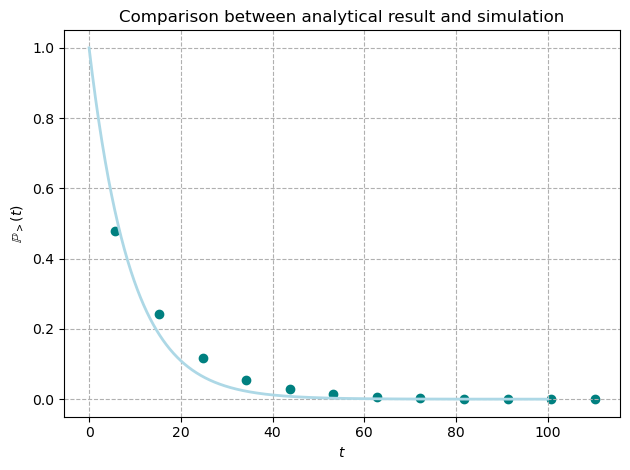

In [10]:
# 1. case (different lambda_i for each neuron)
t = T*dt
delta = n*dt/2
# I compute now the cumulative probability of observing an avalanche smaller than a certain t
counts, bins = np.histogram(avalanche_duration, bins=12)

# analytic_distribution = (1-((1-delta/(n*r))**n))**(n*np.linspace(0, T*dt, T)/(delta))
analytic_distribution = (1-np.exp(-delta/r))**(n*np.linspace(0, T/t, T)/(delta))
# analytic_distribution = analytic_distribution/np.sum(analytic_distribution)
plt.plot(np.linspace(0, T/t, T), analytic_distribution, color='lightblue', 
         lw=2, label='Analytical result')

cumulative = np.cumsum(counts/np.sum(counts))
# Then, 1-cumulative gives back the P(>t) found analytically:
probs = 1-cumulative
plt.scatter(((bins[1:]+bins[:-1])/2), probs, marker='o', color='teal', label='Simulation')

# plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{P}_> (t)$')
plt.title('Comparison between analytical result and simulation')
plt.grid(ls='--')
# plt.ylim((0, max(analytic_distribution[1:])))
plt.tight_layout()
plt.show()

In [11]:
# 2. Same firing rates for each neuron
firing_rates_at_time_t = np.array([-np.log(1-np.random.uniform(size=int(T/dt)))/r]*n)
# Homogeneous step:
prob_of_spike = firing_rates_at_time_t*dt
validate_prob = np.random.uniform(size=(firing_rates_at_time_t.shape))
mask = validate_prob < prob_of_spike
firing_rates_at_time_t[~mask] = 0 

# In this manner, a spike train has been generated for a homogeneous Poisson process
# For an inhomogeneous process the rejection sampling and the thinning techniques are introduced  
firing_rates_max = firing_rates_at_time_t.max(axis=1)
# Thinning method:
new_mask = np.array([firing_rates_at_time_t[i]/firing_rates_max[i] for i in range(n)]) < np.random.uniform(size=(firing_rates_at_time_t.shape))
firing_rates_at_time_t[new_mask] = 0    # set these elements to 0: Thinning technique
mask_tot = firing_rates_at_time_t != 0  # mask resembling where the firing rates are not 0

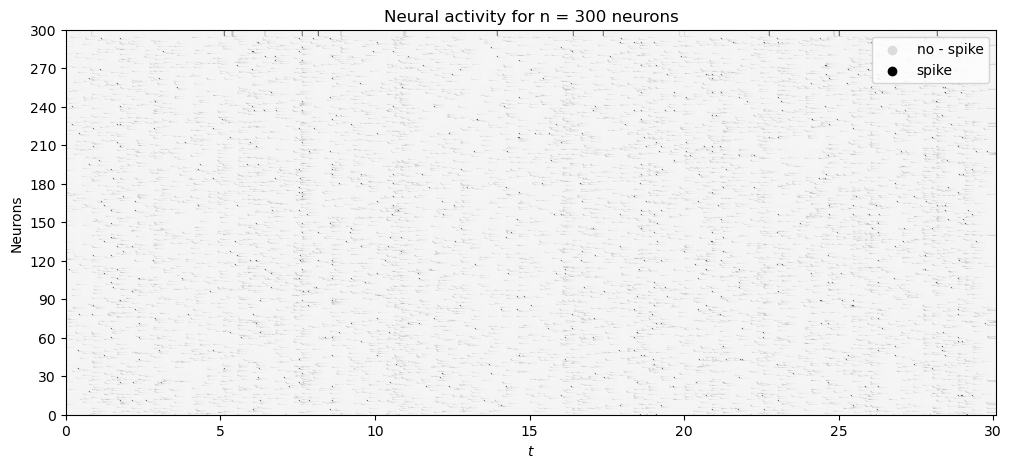

In [12]:
# Plot of the activity distribution of each neuron in time
tau = 3*T
x = np.arange(0, T, dt)[:tau]
X, Y = np.meshgrid(x, np.arange(mask_tot.shape[0]))
colors = np.where(mask_tot == 0, 'whitesmoke', 'black')[:, :tau]
plt.figure(figsize=(12, 5))
spacing = int(n/10)
for i in range(n):
    plt.scatter(X[i, :], spacing*Y[i, :], marker=',', color=colors[i, :], alpha=0.7)
plt.scatter([], [], label=f'no - spike', color='gainsboro')
plt.scatter([], [], label=f'spike', color='black')
plt.xlim((0, x[-1]+0.1))
plt.yticks(np.arange(0, n+spacing, spacing)*spacing, np.arange(0, n+spacing, spacing))
plt.ylim((0, spacing*n))
plt.title(f'Neural activity for n = {n} neurons')
plt.xlabel(r'$t$')
plt.ylabel(f'Neurons')
plt.legend(loc='upper right')
plt.show()

Immediately one can note a difference with the plot shown before for the case 1.: there exists a pattern between the neurons and the spiking behavoiur of neuron $i$ is not independent on the $j$-th neuron, as expected for costruction.

In [13]:
# # firing rate plot
# fig, ax = plt.subplots(2, 2, figsize=(10, 8))
# for k, i in enumerate(rand_neuron_visual):
#     row, col = bin(k).split('b')[-1].zfill(2)
#     ax[int(row), int(col)].vlines((np.arange(0, T, dt))[:1000], 0, mask_tot[i][:1000], color='k')
#     ax[int(row), int(col)].set_xlabel(r'$t$')
#     ax[int(row), int(col)].set_ylabel(f'Spikes')
#     ax[int(row), int(col)].set_title(f'Spike train for neuron {i+1}: inhomogeneous process')
#     ax[int(row), int(col)].set_yticks([])

# plt.tight_layout()
# plt.show()

Keeping in mind the avalanche definition, as before one can easily compute:

In [14]:
# 'mask_tot' describes where the firing rates are different than zero
# Find where no neuron is spiking: so, a column in the 'mask_tot' 
# variable where all elements are equal to 0
# I keep track of the times when this happens (if it happens)
no_spike_t = np.where(mask_tot.sum(axis=0) == 0)[0]
no_spike_t = np.insert(no_spike_t, 0, 0) # add initial time 0s
avalanche_duration = np.diff(no_spike_t)
avalanche_size_window = np.zeros_like(avalanche_duration)
for i, t in enumerate(no_spike_t[1:]):
    # count the number of spiking neurons in the considered time windows
    avalanche_size_window[i] = mask_tot[:, no_spike_t[i]:t].sum() # ?? here maybe it's a sum over axis = 0: 
                                            # in this way I get the number of neurons spiking at a certain time in the time window
    # in this manner a neuron spiking m times is counted m times

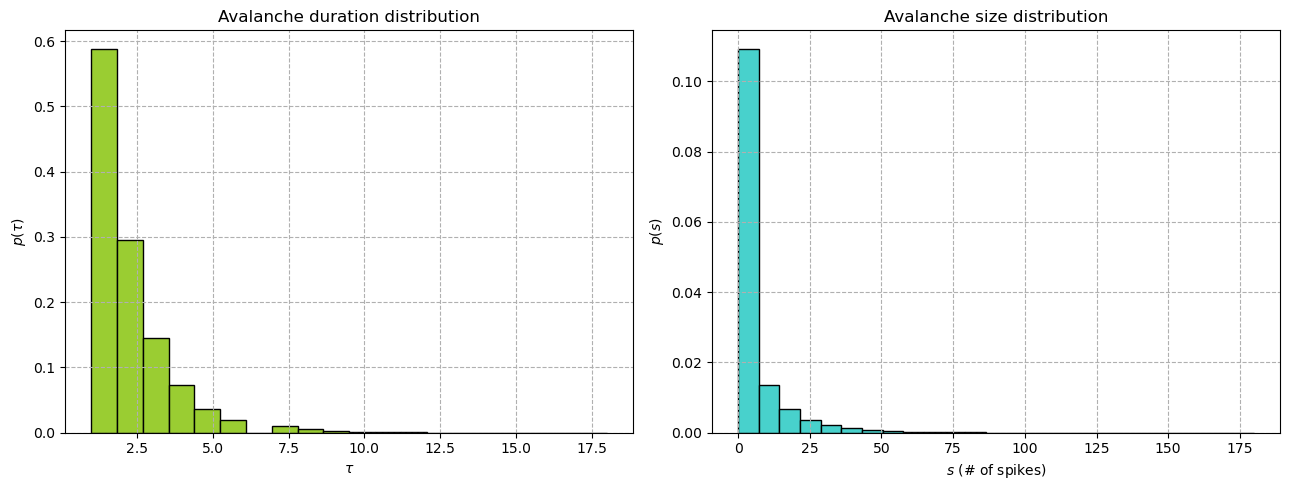

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
t_points, t_bins, _ = ax[0].hist(avalanche_duration, bins=20, 
           facecolor='yellowgreen', edgecolor='black', density=True)
ax[0].grid(ls='--')
ax[0].set_title(f'Avalanche duration distribution')
ax[0].set_xlabel(r'$\tau$')
ax[0].set_ylabel(r'$p(\tau)$')
# ax[0].set_xscale('log')

s_points, s_bins, _ = ax[1].hist(avalanche_size_window, bins=25, 
           facecolor='mediumturquoise', edgecolor='black', density=True)
ax[1].grid(ls='--')
ax[1].set_title(f'Avalanche size distribution')
ax[1].set_xlabel(r'$s$'+f' (# of spikes)')
ax[1].set_ylabel(r'$p(s)$')

plt.tight_layout()
plt.show()

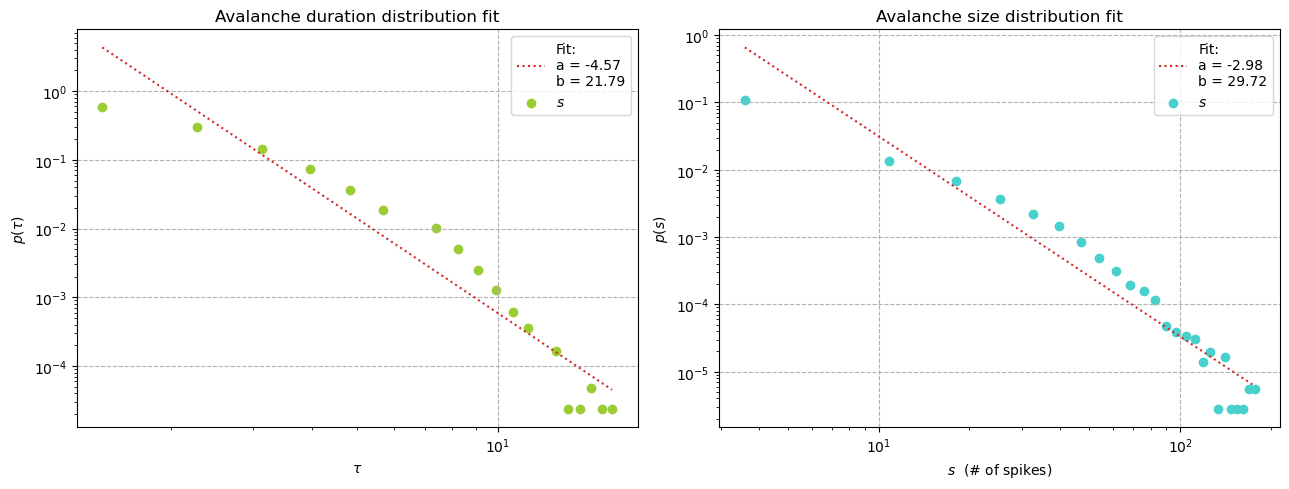

In [16]:
# # Fit the avalanche size distribution
# xx = (s_bins[1:]+s_bins[:-1])/2
# popt, pcov = curve_fit(lambda x, a, b : a*x+b, xx[s_points!=0], np.log(s_points[s_points!=0])) # excluding first bin
# x = np.linspace(min(xx), max(xx), 100)
# theor_p = (lambda x, a, b : np.exp(b+x*a))(x, *popt)

# # Fit the avalanche duration distribution
# xx_t = (t_bins[1:]+t_bins[:-1])/2
# popt_t, pcov_t = curve_fit(lambda x, a, b : a*x+b, xx_t[t_points!=0], np.log(t_points[t_points!=0])) # excluding first bin
# x_t = np.linspace(min(xx_t), max(xx_t), 100)
# theor_t = (lambda x, a, b : np.exp(b+x*a))(x_t, *popt_t)

# Fit the avalanche size distribution
xx = (s_bins[1:]+s_bins[:-1])/2
popt, pcov = curve_fit(lambda x, a, b : b+x*a, np.log(xx[s_points!=0]), np.log(s_points[s_points!=0])) 
x = np.linspace(min(xx), max(xx), 100)
theor_p = (lambda x, a, b : np.exp(b)*x**a)(x, *popt)

# Fit the avalanche duration distribution
xx_t = (t_bins[1:]+t_bins[:-1])/2
popt_t, pcov_t = curve_fit(lambda x, a, b : b+x*a, np.log(xx_t[t_points!=0]), np.log(t_points[t_points!=0])) 
x_t = np.linspace(min(xx_t), max(xx_t), 100)
theor_t = (lambda x, a, b : np.exp(b)*x**a)(x_t, *popt_t)


fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].plot(x_t, theor_t, color='tab:red', ls=':', label=f'Fit:\na = {round(popt_t[0], 2)}\nb = {round(np.exp(popt_t[1]), 2)}')
ax[0].scatter(xx_t, t_points, marker='o', color='yellowgreen', label=r'$s$')
ax[0].set_xlabel(r'$\tau$')
ax[0].set_ylabel(r'$p(\tau)$')
ax[0].grid(ls='--')
ax[0].set_title(f'Avalanche duration distribution fit')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].plot(x, theor_p, color='tab:red', ls=':', label=f'Fit:\na = {round(popt[0], 2)}\nb = {round(np.exp(popt[1]), 2)}')
ax[1].scatter(xx, s_points, marker='o', color='mediumturquoise', label=r'$s$')
ax[1].set_xlabel(r'$s$'+f'  (# of spikes)')
ax[1].set_ylabel(r'$p(s)$')
ax[1].grid(ls='--')
ax[1].set_title(f'Avalanche size distribution fit')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()

plt.tight_layout()
plt.show()

The picture above shows a **power law** behaviour of the avalanche size and duration distribution.

The points follow a power law distribution of the form $p(s)=b s^{a}$.

If instead (as before) one simply counts the number of active neurons at each time step $dt$, the distribution followed is a power law and no longer a Gaussian. The higher the number of neurons $n$ the closer the exponent $a$ gets to $\sim -1.5$. In the plot below the power law behaviour is presented.

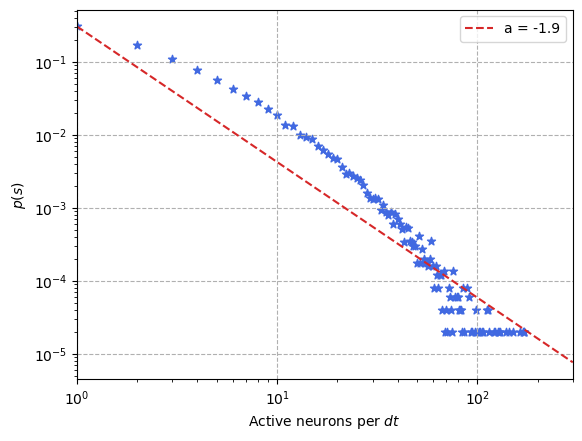

In [17]:
# Compute the probability of an avalanche in the case of an inhomogeneous Poisson process
active_neurons_per_dt = mask_tot.sum(axis=0) 
# power_law = avalanche_size**(-1.5)
# power_law /= np.sum(power_law)

power_law = np.array([(active_neurons_per_dt == i).sum() for i in np.unique(active_neurons_per_dt)[1:]])
power_law = power_law/np.sum(power_law)

popt, pcov = curve_fit(lambda x, a: a*x+np.log(power_law[0]), np.log(np.unique(active_neurons_per_dt)[1:]), np.log(power_law))
x = np.linspace(1, n, n)
theor = (lambda x, a: power_law[0]*x**a)(x, *popt)

plt.scatter(np.unique(active_neurons_per_dt)[1:], power_law, color='royalblue', marker='*')
plt.plot(x, theor, color='tab:red', ls='--', label=f'a = {round(popt[0], 1)}')#\nb = {round(np.exp(popt[1]), 1)}')
plt.xlabel(r'Active neurons per $dt$')
plt.xlim((1, n))
plt.ylabel(r'$p(s)$')
plt.xscale('log')
plt.yscale('log')
plt.grid(ls='--')
plt.legend()
plt.show()

To compute the probability of an **avalanche** (in the case of an inhomogeneous Poisson process), one has to consider the probability 
\begin{equation*}
    \mathbb{P}_> (t\big\vert\lambda_1, \lambda_2, \dots, \lambda_T)
\end{equation*}
of having an avalanche of duration bigger than $t=T\cdot dt$, given the sequence of firing rates $\lambda_t^{(i)}=r(t_j^{(i)})$. 
For $n$ neurons, $dt = \delta/n$ so that $T = t\cdot n/\delta$, the probability of a spike in $[t_j, t_j+dt]$ is $1-(1-\lambda_j dt)^n$. 

$\mathbb{P}_>$ can be computed recursively, considering the probability of at least one spike for $T$ total timesteps. Eventually, considering the exponential distribution $p(\lambda_t) = r \exp \big[-r\lambda_t \big]$, from which $\lambda_t^{(i)}$ is sampled, after integrating one gets to the final result: 
\begin{equation*}
    \mathbb{P}_> (t) = \biggl[1-\frac{r}{\delta+r} \biggr]^{\frac{n t}{\delta}}
\end{equation*}

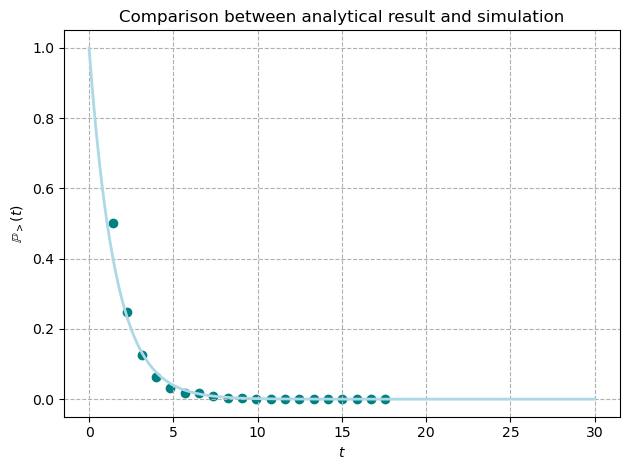

In [18]:
# 2. case (same lambda_i for each neuron)
delta = dt*n
t = T*dt
# I compute now the cumulative probability of observing an avalanche smaller than a certain t
counts, bins = np.histogram(avalanche_duration, bins=20)

analytic_distribution = (1-r/(delta+r))**(n*np.linspace(0, delta*T*dt, T)/t/(delta))
# analytic_distribution = analytic_distribution/np.sum(analytic_distribution)
plt.plot(np.linspace(0, delta*T*dt, T), analytic_distribution, color='lightblue', 
         lw=2, label='Analytical result')

cumulative = np.cumsum(counts/np.sum(counts))
# Then, 1-cumulative gives back the P(>t) found analytically:
probs = 1-cumulative
plt.scatter((bins[1:]+bins[:-1])/2, probs, marker='o', color='teal', label='Simulation')

# plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{P}_> (t)$')
plt.title('Comparison between analytical result and simulation')
plt.grid(ls='--')
# plt.ylim((0, max(analytic_distribution[1:])))
plt.tight_layout()
plt.show()